# SF Data Feature Engineering

In [1]:
# !pip install s2sphere
# !pip install mapsplotlib

In [1]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.sql import SQLContext
from pyspark.ml.feature import VectorAssembler
import s2sphere

## Connect

In [2]:
conf = SparkConf().setAppName("msds697_project")
sc = SparkContext(conf=conf)
sc.setLogLevel("OFF")

In [3]:
ss = SparkSession.builder.getOrCreate()

## Import data and preprocess

In [4]:
def toFloatSafe(v):
    try:
        return float(v)
    except ValueError:
        return v

In [18]:
sf_header = "lat_y,long_y,lat_x,long_x,dt_ts_y,dt_ts_x".split(",")

sf_new_header = ['end_lat',
                 'end_lon',
                 'start_lat',
                 'start_lon',
                 'trip_dropoff_datetime',
                 'trip_pickup_datetime']

sf_data = sc.textFile("data/sf_data.csv")\
            .map(lambda x:  x.split(","))\
            .filter(lambda x: (len(x) == len(sf_header)) & (x != sf_header))\
            .map(lambda x: [toFloatSafe(v) for v in x])

### Clean Outside City Data

In [19]:
SF_lat_min = 37.71
SF_lat_max = 37.82
SF_long_max = -122.36
SF_long_min = -122.52

sf_data = sf_data.filter(lambda x: (x[0] >= SF_lat_min) & (x[0] <= SF_lat_max))\
                 .filter(lambda x: (x[2] >= SF_lat_min) & (x[2] <= SF_lat_max))\
                 .filter(lambda x: (x[1] >= SF_long_min) & (x[1] <= SF_long_max))\
                 .filter(lambda x: (x[3] >= SF_long_min) & (x[3] <= SF_long_max))

In [20]:
sf_df = sf_data.toDF(sf_new_header)

In [21]:
sf_pddf = sf_df.toPandas()

In [22]:
sf_pddf.head(5)

,end_lat,end_lon,start_lat,start_lon,trip_dropoff_datetime,trip_pickup_datetime
0,37.75552,-122.41438,37.74977,-122.39724,2008-05-17 07:55:58,2008-05-17 07:51:10
1,37.75177,-122.43095,37.75053,-122.42086,2008-05-17 08:21:48,2008-05-17 08:18:06
2,37.77188,-122.41825,37.77173,-122.41838,2008-05-17 08:45:51,2008-05-17 08:43:51
3,37.79160,-122.41249,37.75240,-122.41842,2008-05-17 09:34:28,2008-05-17 09:18:40
4,37.74669,-122.40395,37.73335,-122.40556,2008-05-17 10:29:15,2008-05-17 10:27:23


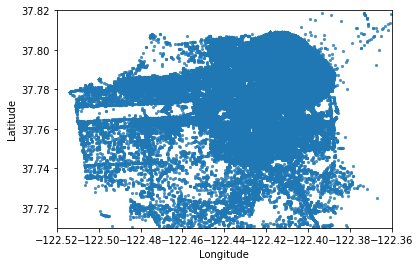

In [23]:
fig, ax = plt.subplots(ncols=1, nrows=1)
ax.scatter(sf_pddf.start_lon, sf_pddf.start_lat, s=10, lw=0, alpha=0.8)
ax.set_xlim(SF_long_min, SF_long_max)
ax.set_ylim(SF_lat_min, SF_lat_max)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.show()

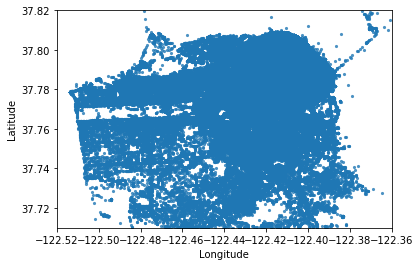

In [24]:
fig, ax = plt.subplots(ncols=1, nrows=1)
ax.scatter(sf_pddf.end_lon, sf_pddf.end_lat, s=10, lw=0, alpha=0.8)
ax.set_xlim(SF_long_min, SF_long_max)
ax.set_ylim(SF_lat_min, SF_lat_max)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.show()

## Trip-level features

In [11]:
def lowercase_cols(df):
    for col in df.columns:
        new_col = col.lower()
        if new_col != col:
            df = df.withColumnRenamed(col, new_col)
    return df

def toDatetime(df, col_name):
    df = df.withColumn(col_name + "_2", to_timestamp(df[col_name], 'yyyy-MM-dd HH:mm:ss'))
    df = df.drop(col_name).withColumnRenamed(col_name + "_2", col_name)
    return df

nyc_df = lowercase_cols(nyc_df)

Extract day of week, add "is_weekend" flag when trip starts OR ends during the weekend

In [12]:
cell_level = 13

def coord_to_id_fun(x, cell_level=cell_level):
    lat, lon = x
    from s2sphere import CellId, LatLng
    cell_id = CellId.from_lat_lng(LatLng.from_degrees(lat, lon))\
    .parent(cell_level).to_token()
    return cell_id

def get_corners(s2CellId_str, cell_level=cell_level+1, cluster=1):
    from s2sphere import CellId, LatLng, Cell
    c1 = Cell(CellId(int(s2CellId_str,16)<<(60 - 2*cell_level)))
    v0 = LatLng.from_point(c1.get_vertex(0)) # lat/lon of upper/left corner
    v1 = LatLng.from_point(c1.get_vertex(1)) # lat/lon of lower/left corner
    v2 = LatLng.from_point(c1.get_vertex(2)) # lat/lon of lower/right corner
    v3 = LatLng.from_point(c1.get_vertex(3)) # lat/lon of upper/right corner
    return ((v0.lat().degrees, v0.lng().degrees, cluster),
            (v1.lat().degrees, v1.lng().degrees, cluster),
            (v2.lat().degrees, v2.lng().degrees, cluster),
            (v3.lat().degrees, v3.lng().degrees, cluster))

def distance_fun(x):
    import math
    lat1, lon1, lat2, lon2 = x
    radius = 6371 # km

    dlat = math.radians(lat2-lat1)
    dlon = math.radians(lon2-lon1)
    a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) \
        * math.cos(math.radians(lat2)) * math.sin(dlon/2) * math.sin(dlon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = radius * c
    return d

coord_to_id = udf(lambda x: coord_to_id_fun(x), StringType())
distance = udf(lambda x: distance_fun(x), FloatType())

In [13]:
from pyspark.sql import functions as F

def process_features(df):
    df = toDatetime(df, "trip_pickup_datetime")
    df = toDatetime(df, "trip_dropoff_datetime")

    df = df.withColumn('dow_dropoff', date_format('trip_dropoff_datetime', 'u').cast(IntegerType()))\
    .withColumn('strdow_dropoff', date_format('trip_dropoff_datetime', 'E'))\
    .withColumn('dow_pickup', date_format('trip_pickup_datetime', 'u').cast(IntegerType()))\
    .withColumn('strdow_pickup', date_format('trip_pickup_datetime', 'E'))\
    .withColumn('hour_pickup', date_format('trip_pickup_datetime', 'H').cast(IntegerType()))\
    .withColumn('hour_dropoff', date_format('trip_dropoff_datetime', 'H').cast(IntegerType()))

    df = df.withColumn("is_weekend", when((df.dow_pickup >= 6) | (df.dow_dropoff >= 6), 1).otherwise(0))

    df = df.withColumn("start_cell_id", coord_to_id(array("start_lat", "start_lon")))
    df = df.withColumn("end_cell_id", coord_to_id(array("end_lat", "end_lon")))
    df = df.withColumn("distance_km", distance(array("start_lat", "start_lon","end_lat", "end_lon")))


    timeFmt = "yyyy-MM-dd HH:mm:ss"
    timediff = (F.unix_timestamp('trip_dropoff_datetime', format=timeFmt)
                - F.unix_timestamp('trip_pickup_datetime', format=timeFmt))
    df = df.withColumn("trip_duration", timediff)

    return df

In [25]:
sf_df = process_features(sf_df)
sf_df = sf_df.withColumn("trip_distance", nyc_factor*sf_df.distance_km)
sf_df.cache()

DataFrame[end_lat: double, end_lon: double, start_lat: double, start_lon: double, trip_pickup_datetime: timestamp, trip_dropoff_datetime: timestamp, dow_dropoff: int, strdow_dropoff: string, dow_pickup: int, strdow_pickup: string, hour_pickup: int, hour_dropoff: int, is_weekend: int, start_cell_id: string, end_cell_id: string, distance_km: float, trip_duration: bigint, trip_distance: double]

### Clean Unreasonable Trips

In [26]:
sf_df.approxQuantile("trip_duration", [.0], 0)

[1.0]

In [27]:
sf_df.approxQuantile("trip_duration", [0.01], 0)

[45.0]

In [28]:
sf_df.approxQuantile("trip_duration", [0.99], 0)

[1751.0]

In [29]:
sf_df.approxQuantile("trip_duration", [1.], 0)

[119615.0]

In [30]:
sf_df = sf_df.filter(sf_df.trip_duration <= 1800)\
             .filter(sf_df.trip_duration >= 30)

In [35]:
sf_df.rdd.saveAsPickleFile("sf_df_trip_level_cleaned")

In [32]:
sf_pddf = sf_df.toPandas()

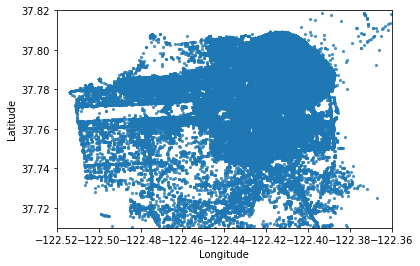

In [33]:
fig, ax = plt.subplots(ncols=1, nrows=1)
ax.scatter(sf_pddf.start_lon, sf_pddf.start_lat, s=10, lw=0, alpha=0.8)
ax.set_xlim(SF_long_min, SF_long_max)
ax.set_ylim(SF_lat_min, SF_lat_max)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.show()

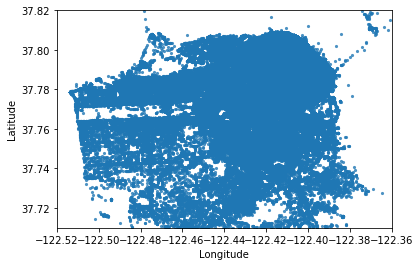

In [34]:
fig, ax = plt.subplots(ncols=1, nrows=1)
ax.scatter(sf_pddf.end_lon, sf_pddf.end_lat, s=10, lw=0, alpha=0.8)
ax.set_xlim(SF_long_min, SF_long_max)
ax.set_ylim(SF_lat_min, SF_lat_max)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.show()

## Cell-level Features

### Divide areas into cells

In [31]:
%%time
sf_df.count()

CPU times: user 706 µs, sys: 960 µs, total: 1.67 ms
Wall time: 103 ms


394017

### Gather features by cell

In [38]:
def pivot_column(df, group_col, pv_col, prefix):
    orig_cols = set(df.columns)
    new_df = df.groupBy(group_col).pivot(pv_col).count()
    new_cols = new_df.columns
    new_cols = [c if c in orig_cols else prefix + c for c in new_cols]
    new_df = new_df.toDF(*new_cols)
    new_df = new_df.na.fill(0, list(set(new_cols) - orig_cols))
    return new_df

In [39]:
def merge_dfs(dfs):
    first_df = None
    for df in dfs:
        if first_df is None:
            first_df = df
        else:
            first_df = first_df.join(df, "cell_id", "left_outer")
    return first_df

In [40]:
def create_features(df):
    dow_pickup_df = pivot_column(df, group_col = "start_cell_id", 
                                     pv_col = "dow_pickup", prefix = "dow_pickup_")\
                                     .withColumnRenamed("start_cell_id", "cell_id")

    dow_dropoff_df = pivot_column(df, group_col = "end_cell_id", 
                                      pv_col = "dow_dropoff", prefix = "dow_dropoff_")\
                                      .withColumnRenamed("end_cell_id", "cell_id")

    hr_pickup_wkday_df = pivot_column(df.filter(df.dow_pickup<6), 
                                                               group_col = "start_cell_id", 
                                                               pv_col = "hour_pickup", 
                                                               prefix = "hr_pickup_wkday")\
                                                               .withColumnRenamed("start_cell_id", "cell_id")

    hr_dropoff_wkday_df = pivot_column(df.filter(df.dow_dropoff<6), 
                                                               group_col = "end_cell_id", 
                                                               pv_col = "hour_dropoff", 
                                                               prefix = "hr_dropoff_wkday")\
                                                               .withColumnRenamed("end_cell_id", "cell_id")

    hr_pickup_wkend_df = pivot_column(df.filter(df.dow_pickup>=6), 
                                                               group_col = "start_cell_id", 
                                                               pv_col = "hour_pickup", 
                                                               prefix = "hr_pickup_wkend")\
                                                               .withColumnRenamed("start_cell_id", "cell_id")

    hr_dropoff_wkend_df = pivot_column(df.filter(df.dow_dropoff>=6), 
                                                               group_col = "end_cell_id", 
                                                               pv_col = "hour_dropoff", 
                                                               prefix = "hr_dropoff_wkend")\
                                                               .withColumnRenamed("end_cell_id", "cell_id")

    pickup_km_df = df.groupBy("start_cell_id").agg(avg("distance_km"),stddev("distance_km"))\
                        .withColumnRenamed("avg(distance_km)", "avg_pickup_km")\
                        .withColumnRenamed("stddev_samp(distance_km)", "std_pickup_km")\
                        .withColumnRenamed("start_cell_id", "cell_id")

    dropoff_km_df = df.groupBy("end_cell_id").agg(avg("distance_km"),stddev("distance_km"))\
                        .withColumnRenamed("avg(distance_km)", "avg_dropoff_km")\
                        .withColumnRenamed("stddev_samp(distance_km)", "std_dropoff_km")\
                        .withColumnRenamed("end_cell_id", "cell_id")
    
    discrete_pickup_cell_no = df.groupBy("end_cell_id")\
                                .agg(countDistinct("start_cell_id").alias("discrete_pickup_cell_no"))\
                                .withColumnRenamed("end_cell_id", "cell_id")
    
    discrete_dropoff_cell_no = df.groupBy("start_cell_id")\
                                .agg(countDistinct("end_cell_id").alias("discrete_dropoff_cell_no"))\
                                .withColumnRenamed("start_cell_id", "cell_id")

    cell_df = merge_dfs([dow_pickup_df, dow_dropoff_df, 
              hr_pickup_wkday_df, hr_dropoff_wkday_df,
              hr_pickup_wkend_df, hr_dropoff_wkend_df,
              pickup_km_df, dropoff_km_df,
              discrete_pickup_cell_no, discrete_dropoff_cell_no
             ])

    cell_df = cell_df.na.fill(0)

    cell_df.printSchema()
    
    feature_columns = [c for c in cell_df.columns if c != "cell_id"]

    for c in feature_columns:
        cell_df = cell_df.withColumn(c+"_f", cell_df[c].cast(FloatType()))
        cell_df = cell_df.drop(c)
        cell_df = cell_df.withColumnRenamed(c+"_f",c)

    cell_df.cache()

    print(cell_df.count(), len(cell_df.columns))

    return cell_df

In [ ]:
pickleRdd = sc.pickleFile("sf_df_trip_level_cleaned").collect()
sf_df = sc.createDataFrame(pickleRdd)

In [45]:
%%time
sf_cell_df = create_features(sf_df)
sf_cell_df.cache()
sf_cell_df.count()

root
 |-- cell_id: string (nullable = true)
 |-- dow_pickup_1: long (nullable = true)
 |-- dow_pickup_2: long (nullable = true)
 |-- dow_pickup_3: long (nullable = true)
 |-- dow_pickup_4: long (nullable = true)
 |-- dow_pickup_5: long (nullable = true)
 |-- dow_pickup_6: long (nullable = true)
 |-- dow_pickup_7: long (nullable = true)
 |-- dow_dropoff_1: long (nullable = true)
 |-- dow_dropoff_2: long (nullable = true)
 |-- dow_dropoff_3: long (nullable = true)
 |-- dow_dropoff_4: long (nullable = true)
 |-- dow_dropoff_5: long (nullable = true)
 |-- dow_dropoff_6: long (nullable = true)
 |-- dow_dropoff_7: long (nullable = true)
 |-- hr_pickup_wkday0: long (nullable = true)
 |-- hr_pickup_wkday1: long (nullable = true)
 |-- hr_pickup_wkday2: long (nullable = true)
 |-- hr_pickup_wkday3: long (nullable = true)
 |-- hr_pickup_wkday4: long (nullable = true)
 |-- hr_pickup_wkday5: long (nullable = true)
 |-- hr_pickup_wkday6: long (nullable = true)
 |-- hr_pickup_wkday7: long (nullable =

In [49]:
sf_cell_df.rdd.saveAsPickleFile("sf_df_cell_level")

## Vectorize features

In [238]:
from pyspark.ml.feature import StandardScaler

def vectorize(cell_df, city):
    feature_columns = [c for c in cell_df.columns if c != "cell_id"]
    va = VectorAssembler(outputCol="features", inputCols=feature_columns)
    vectorized_df = va.transform(cell_df)
    vectorized_df = vectorized_df.select("features")

    scaler = StandardScaler(inputCol="features",\
             outputCol="scaledFeatures")
    scalerModel =  scaler.fit(vectorized_df)
    vectorized_df = scalerModel.transform(vectorized_df)
    
    vectorized_df = vectorized_df.withColumn('row_index', monotonically_increasing_id())
    cell_df = cell_df.withColumn('row_index', monotonically_increasing_id())
    vectorized_df = vectorized_df.join(cell_df.select("row_index", "cell_id"), on=["row_index"]).sort("row_index").drop("row_index")
    vectorized_df = vectorized_df.withColumn("city", lit(city))

    return vectorized_df

In [ ]:
pickleRdd = sc.pickleFile("sf_df_cell_level").collect()
sf_cell_df = sc.createDataFrame(pickleRdd)

In [241]:
%%time
sf_vectorized_df = vectorize(sf_cell_df, city="SF")
sf_vectorized_df.cache()
sf_vectorized_df.count()

CPU times: user 16 ms, sys: 8 ms, total: 24 ms
Wall time: 11.4 s


In [181]:
sf_vectorized_df.show(2)

+--------------------+--------------------+----+
|            features|      scaledFeatures|city|
+--------------------+--------------------+----+
|(114,[0,1,3,7,8,9...|(114,[0,1,3,7,8,9...|  SF|
|(114,[3,12,13,37,...|(114,[3,12,13,37,...|  SF|
+--------------------+--------------------+----+
only showing top 2 rows



## Plotting

### Common outbound cells

In [178]:
sf_popular_cell_id = sf_df.groupBy("end_cell_id").count().orderBy("count", ascending=False).first().asDict()["end_cell_id"]
sf_unpopular_cell_id = sf_df.groupBy("end_cell_id").count().orderBy("count", ascending=True).first().asDict()["end_cell_id"]

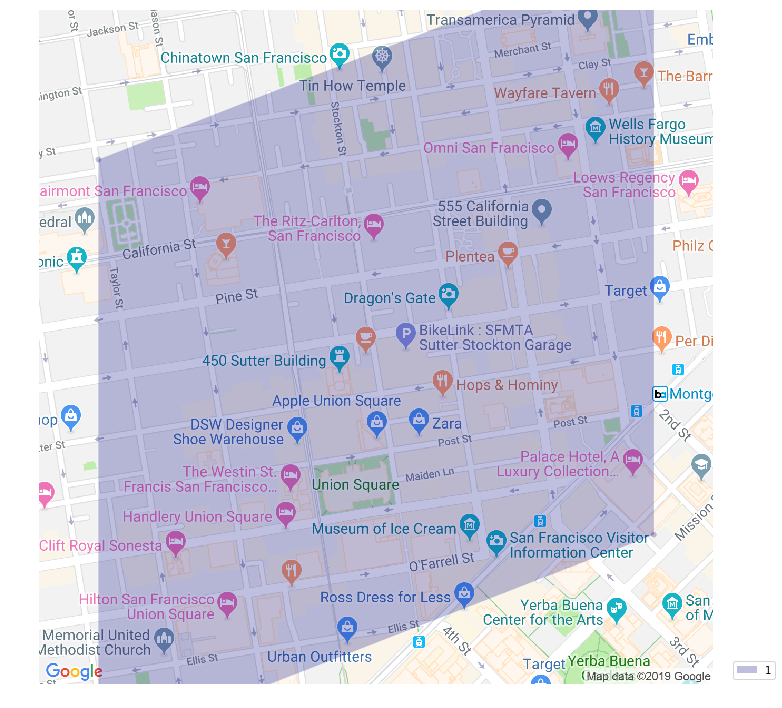

In [179]:
show_cell(sf_popular_cell_id)